In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz
!tar -xvf spark-3.1.1-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install pyspark

tar: spark-3.1.1-bin-hadoop2.7.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [2]:
from pyspark.sql import SparkSession

In [3]:
from pyspark import SparkConf,SparkContext

In [4]:
from pyspark.sql import SQLContext
sc = SparkContext()
sql_context = SQLContext(sc)

In [5]:
spark = SparkSession.builder.appName("census_data").getOrCreate()

In [6]:
data = spark.read.csv('/content/censusdata.csv', header = True)

In [7]:
data.printSchema()

root
 |-- age: string (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: string (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: string (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: string (nullable = true)
 |-- capital_loss: string (nullable = true)
 |-- hours_per_week: string (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)



In [8]:
#Data Preprocessing
type_cast=['age','fnlwgt','education_num','capital_gain','capital_loss','hours_per_week',]
for i in type_cast: 
    data= data.withColumn(i,data[i].cast("double"))


In [9]:
import pandas as pd
pd.DataFrame({'column':data.columns,'type':data.dtypes})

,column,type
0,age,"(age, double)"
1,workclass,"(workclass, string)"
2,fnlwgt,"(fnlwgt, double)"
3,education,"(education, string)"
4,education_num,"(education_num, double)"
5,marital_status,"(marital_status, string)"
6,occupation,"(occupation, string)"
7,relationship,"(relationship, string)"
8,race,"(race, string)"
9,sex,"(sex, string)"


In [10]:
#Category Indexing & One-Hot Encoding
#Category Indexing using string indexing for all categorical columns

from pyspark.ml.feature import StringIndexer, OneHotEncoder
categoricalCols = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex"] 
# The following two lines are estimators. They return functions that we will later apply to transform the dataset.
stringIndexer = StringIndexer(inputCols=categoricalCols, outputCols=[x + "Index" for x in categoricalCols]) 
encoder = OneHotEncoder(inputCols=stringIndexer.getOutputCols(), outputCols=[x + "OHE" for x in categoricalCols])  

#Label Indexing for income column as income
# The label column ("income") is also a string value - it has two possible values, "<=50K" and ">50K". 
# Convert it to a numeric value using StringIndexer.
labelToIndex = StringIndexer(inputCol="income", outputCol="label")

In [11]:
from pyspark.ml.feature import VectorAssembler 
#Use Vector assembler to get a single vector column for features
# This includes both the numeric columns and the one-hot encoded binary vector columns in our dataset.
numericCols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
assemblerInputs = [c + "OHE" for c in categoricalCols] + numericCols
vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

**Logistic Regression**





In [12]:
from pyspark.ml.classification import LogisticRegression 
lr = LogisticRegression(featuresCol="features", labelCol="label", regParam=1.0)

In [53]:
from pyspark.ml import Pipeline 
#Make it as an array of stages so that it can be passed to a pipeline 
# Define the pipeline based on the stages created in previous steps.
#Generate a DataFrame which can hold a variety of datatypes including feature vector
pipeline = Pipeline(stages=[stringIndexer, encoder, labelToIndex, vecAssembler, lr]) 
# Define the pipeline model.
#Estimator that can fit on a DataFrame to produce a model
pipelineModel = pipeline.fit(data) 
# Apply the pipeline model to the test dataset.
#Transform the DataFrame with features to DataFrame with predictions
predDF = pipelineModel.transform(data)
#Check the distribution of income in  dataset
predDF.show()

+----+----------------+--------+------------+-------------+------------------+-----------------+--------------+-----+------+------------+------------+--------------+--------------+------+--------------+---------+---------------+-----------------+--------------+-------------------+--------+---------------+-------------+-------------+-----------------+--------------+-------------+---------------+-----+--------------------+--------------------+--------------------+----------+
| age|       workclass|  fnlwgt|   education|education_num|    marital_status|       occupation|  relationship| race|   sex|capital_gain|capital_loss|hours_per_week|native_country|income|educationIndex|raceIndex|occupationIndex|relationshipIndex|workclassIndex|marital_statusIndex|sexIndex|relationshipOHE|       sexOHE|      raceOHE|marital_statusOHE|  educationOHE| workclassOHE|  occupationOHE|label|            features|       rawPrediction|         probability|prediction|
+----+----------------+--------+------------

In [14]:
#Check the shape of the datasets
trainDF, testDF = data.randomSplit([0.8, 0.2], seed=42)
print(trainDF.count()) 
print(testDF.count())

74021
18540


In [57]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[stringIndexer, encoder, labelToIndex, vecAssembler, lr])
pipelineModel = pipeline.fit(trainDF)
predDF = pipelineModel.transform(testDF)
#Check the distribution of income  (0,1) in train and test dataset
predDF.show()

+----+-----------+--------+------------+-------------+--------------+------------+--------------+------------------+------+------------+------------+--------------+--------------+------+--------------+---------+---------------+-----------------+--------------+-------------------+--------+---------------+-------------+-------------+-----------------+--------------+-------------+--------------+-----+--------------------+--------------------+--------------------+----------+
| age|  workclass|  fnlwgt|   education|education_num|marital_status|  occupation|  relationship|              race|   sex|capital_gain|capital_loss|hours_per_week|native_country|income|educationIndex|raceIndex|occupationIndex|relationshipIndex|workclassIndex|marital_statusIndex|sexIndex|relationshipOHE|       sexOHE|      raceOHE|marital_statusOHE|  educationOHE| workclassOHE| occupationOHE|label|            features|       rawPrediction|         probability|prediction|
+----+-----------+--------+------------+--------

In [16]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
bcEvaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
print(f"Area under ROC curve: {bcEvaluator.evaluate(predDF)}") 
mcEvaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print(f"Accuracy: {mcEvaluator.evaluate(predDF)}")

Area under ROC curve: 0.8853375921167054
Accuracy: 0.7660194174757281


In [17]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator 
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .build())

In [18]:
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=bcEvaluator, numFolds=3, parallelism = 4)

In [19]:
cvModel = cv.fit(trainDF)

In [20]:
cvPredDF = cvModel.transform(testDF) 
# Evaluate the model's performance based on area under the ROC curve and accuracy 
print(f"Area under ROC curve: {bcEvaluator.evaluate(cvPredDF)}")
print(f"Accuracy: {mcEvaluator.evaluate(cvPredDF)}")

Area under ROC curve: 0.903470605230467
Accuracy: 0.8444983818770226


**Decision Tree**


In [21]:
from pyspark.ml.classification import DecisionTreeClassifier 
DT = DecisionTreeClassifier( featuresCol="features" , labelCol="label", maxDepth=5)

In [22]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[stringIndexer, encoder, labelToIndex, vecAssembler, DT])
pipelineModel = pipeline.fit(trainDF) 
predDF = pipelineModel.transform(testDF)

In [23]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
bcEvaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
print(f"Area under ROC curve: {bcEvaluator.evaluate(predDF)}")
mcEvaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print(f"Accuracy: {mcEvaluator.evaluate(predDF)}")

Area under ROC curve: 0.5884229151865182
Accuracy: 0.8386192017259978


In [24]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(DT.maxDepth, [1, 2, 6, 10])
             .addGrid(DT.maxBins, [20, 40, 80])
             .build())

In [25]:
cv1 = CrossValidator(estimator=DT, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

In [26]:
pipeline = Pipeline(stages=[stringIndexer, encoder, labelToIndex, vecAssembler, cv1])
pipelineModel = pipeline.fit(trainDF)
predDF = pipelineModel.transform(testDF)

In [27]:
bcEvaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
print(f"Area under ROC curve: {bcEvaluator.evaluate(predDF)}")
mcEvaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print(f"Accuracy: {mcEvaluator.evaluate(predDF)}")

Area under ROC curve: 0.7483473239032467
Accuracy: 0.8654800431499461


**RANDOM FOREST**

In [28]:
from pyspark.ml.classification import RandomForestClassifier
# Create an initial RandomForest model
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

In [29]:
from pyspark.ml import Pipeline 
pipeline = Pipeline(stages=[stringIndexer, encoder, labelToIndex, vecAssembler, rf]) 
pipelineModel = pipeline.fit(trainDF)
predDF = pipelineModel.transform(testDF)

In [30]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
# Evaluate model
evaluator = BinaryClassificationEvaluator()
bcEvaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
print(f"Area under ROC curve: {bcEvaluator.evaluate(predDF)}")
mcEvaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print(f"Accuracy: {mcEvaluator.evaluate(predDF)}")

Area under ROC curve: 0.8841568239252947
Accuracy: 0.8325782092772384


In [31]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2, 4, 6])
             .addGrid(rf.maxBins, [20, 60])
             .addGrid(rf.numTrees, [5, 20])
             .build())

In [32]:
cv2 = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

In [33]:
pipeline = Pipeline(stages=[stringIndexer, encoder, labelToIndex, vecAssembler, cv2])
pipelineModel = pipeline.fit(trainDF)
predDF = pipelineModel.transform(testDF)

In [34]:
bcEvaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
print(f"Area under ROC curve: {bcEvaluator.evaluate(predDF)}") 
mcEvaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print(f"Accuracy: {mcEvaluator.evaluate(predDF)}")

Area under ROC curve: 0.8961945814730602
Accuracy: 0.8426105717367853


**Gradient Boosted Tree**


In [35]:
from pyspark.ml.classification import GBTClassifier

In [36]:
gb = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)

In [37]:
pipeline = Pipeline(stages=[stringIndexer, encoder, labelToIndex, vecAssembler, gb])
pipelineModel = pipeline.fit(trainDF) 
predDF = pipelineModel.transform(testDF)

In [38]:
bcEvaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
print(f"Area under ROC curve: {bcEvaluator.evaluate(predDF)}") 
mcEvaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print(f"Accuracy: {mcEvaluator.evaluate(predDF)}")

Area under ROC curve: 0.9079726059384944
Accuracy: 0.8526968716289105


In [39]:
gbparamGrid = (ParamGridBuilder()
             .addGrid(gb.maxDepth, [2, 5, 10])
             .addGrid(gb.maxBins, [10, 20, 40])
             .addGrid(gb.maxIter, [5, 10, 20])
             .build())

In [41]:
evaluator = BinaryClassificationEvaluator()
gbcv = CrossValidator(estimator = gb,
                      estimatorParamMaps = gbparamGrid,
                      evaluator = evaluator,
                      numFolds = 5)

In [42]:
pipeline = Pipeline(stages=[stringIndexer, encoder, labelToIndex, vecAssembler, gbcv]) 
pipelineModel = pipeline.fit(trainDF)
predDF = pipelineModel.transform(testDF)

In [43]:
bcEvaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
print(f"Area under ROC curve: {bcEvaluator.evaluate(predDF)}") 
mcEvaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print(f"Accuracy: {mcEvaluator.evaluate(predDF)}")

Area under ROC curve: 0.9465940637619236
Accuracy: 0.8875943905070118


**Naïve Bayes**

In [44]:
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(labelCol="label", featuresCol="features")

In [45]:
pipeline = Pipeline(stages=[stringIndexer, encoder, labelToIndex, vecAssembler, nb])
pipelineModel = pipeline.fit(trainDF)
predDF = pipelineModel.transform(testDF)

In [46]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
bcEvaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
print(f"Area under ROC curve: {bcEvaluator.evaluate(predDF)}")
 
mcEvaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print(f"Accuracy: {mcEvaluator.evaluate(predDF)}")

Area under ROC curve: 0.37213811331269087
Accuracy: 0.7788025889967638


In [47]:
nbparamGrid = (ParamGridBuilder()
               .addGrid(nb.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
               .build())

In [48]:
nbcv = CrossValidator(estimator = nb,
                    estimatorParamMaps = nbparamGrid,
                    evaluator = evaluator,
                    numFolds = 5)

In [49]:
pipeline = Pipeline(stages=[stringIndexer, encoder, labelToIndex, vecAssembler, nbcv])
pipelineModel = pipeline.fit(trainDF)
predDF = pipelineModel.transform(testDF)

In [50]:
bcEvaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
print(f"Area under ROC curve: {bcEvaluator.evaluate(predDF)}")
mcEvaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print(f"Accuracy: {mcEvaluator.evaluate(predDF)}")

Area under ROC curve: 0.37230287166498044
Accuracy: 0.7788025889967638


**LOGISTIC REGRESSION :-**

**MODEL ACCURACY**
Area under ROC curve: 0.8853
Accuracy: 0.7660

**IMPROVED ACCURACY**
Area under ROC curve: 0.9034
Accuracy: 0.8444

**DECISION TREE :**- 

**MODEL ACCURACY**
Area under ROC curve: 0.5884
Accuracy: 0.8386

**IMPROVED ACCURACY**
Area under ROC curve: 0.7483
Accuracy: 0.8654


**RANDOM FOREST:-**

**MODEL ACCURACY**
Area under ROC curve: 0.8841
Accuracy: 0.8325

**IMPROVED ACCURACY**
Area under ROC curve: 0.8961
Accuracy: 0.8426

**GRADIENT BOOSTED TREE:-**

**MODEL ACCURACY**
Area under ROC curve: 0.9079
Accuracy: 0.8526


**IMPROVED ACCURACY**
Area under ROC curve: 0.9465
Accuracy: 0.8875



**NAIVE BAYES:-**

**MODEL ACCURACY**
Area under ROC curve: 0.3721
Accuracy: 0.7788

**IMPROVED ACCURACY**
Area under ROC curve: 0.3723
Accuracy: 0.7788


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
data = [['LR',0.7660,0.8444],['RF',0.8325,0.8426],['GBT',0.8526,0.8875],['NB',0.7788,0.7788],['DT',0.8386,0.8654]]
df = pd.DataFrame(data, columns = ['MODEL','ACC','IMPROVED_ACC'])

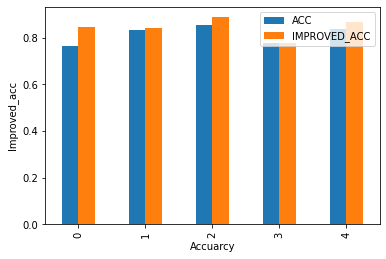

In [18]:
df.plot.bar()  
# plot between 2 attributes
plt.xlabel("Accuarcy")
plt.ylabel("Improved_acc")
plt.show()

**Improved Accuracy:-**
Having regularized hyperparameters in place provides the ability to control the flexibility of the model. This control prevents overfitting and reduction in predictive accuracy on new test data. When hyperparameters are also used for optimization and tuned for a specific dataset, they also impact predictive accuracy.

Having regularized hyperparameters in place provides the ability to control the flexibility of the model. This control prevents overfitting and reduction in predictive accuracy on new test data. When hyperparameters are also used for optimization and tuned for a specific dataset, they also impact predictive accuracy.